### 1. Import dependencies

In [1]:
import os
import copy
import numpy as np
from PIL import Image

In [2]:
import torch

from torchvision import datasets, models, transforms

import torch.nn as nn
import torch.optim as optim

In [3]:
torch.__version__

'0.4.1'

### 2. Create PyTorch data generators

In [4]:
data_dir ='/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small'
data_dir_train = os.path.join(data_dir, 'train')
data_dir_validation = os.path.join(data_dir, 'validation')

img_size = 224
batch_size = 128
epochs = 3

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
            transforms.Resize((img_size,img_size)),
            transforms.RandomResizedCrop(img_size,scale=(0.8,1),ratio=(1,1)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomAffine(10, shear=(0,10)),
            transforms.ToTensor(),
            normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((img_size,img_size)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(data_dir_train, data_transforms['train']),
    'validation': 
    datasets.ImageFolder(data_dir_validation, data_transforms['validation'])
}

dataloaders = {
    phase: torch.utils.data.DataLoader(image_datasets[phase],
                                       batch_size=batch_size,
                                       shuffle=True, num_workers=4)
    for phase in ['train', 'validation']
}

dataset_sizes = {phase: len(image_datasets[phase])
                 for phase in ['train', 'validation']}

### 3. Import pre-trained ResNet50 and stack trainable layers on top of it

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Wrap this in a function so we can easily make the model structure object in '6. Load the best model checkpoint and evaluate it on a sample image'.
# Note that newly constructed modules are trainable (requires_grad=True) by default.
def net():
    model = models.resnet50(pretrained=True).to(device)
    
    for param in model.parameters():
        param.requires_grad = False   
    
    model.fc = nn.Sequential(
                nn.Linear(2048, 128),
                nn.ReLU(inplace=True),
                nn.Linear(128, 2)).to(device)
    return model

In [ ]:
model = net()

### 4. Prepare model checkpointing

In [7]:
model_checkpoint_dir = "./saved_models/pytorch"

if not os.path.exists(model_checkpoint_dir):
    os.makedirs(model_checkpoint_dir)
    print('Created directory: ', model_checkpoint_dir)

model_checkpoint_path = os.path.join(model_checkpoint_dir, "best_models_weights.hdf5")

### 5. Train the model


In [8]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.RMSprop(model.fc.parameters())

In [9]:
def train_model(model, criterion, optimizer, num_epochs=3):

    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history only in train mode
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))

            # deep copy the best model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), model_checkpoint_path)
               
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_weights)
    return model

In [10]:
model_best = train_model(model, criterion, optimizer, num_epochs=epochs)

Epoch 1/1
----------
train Loss: 79.9553 Acc: 0.6675
validation Loss: 0.9589 Acc: 0.9590
Best val Acc: 0.959000
CPU times: user 23min 57s, sys: 3min, total: 26min 58s
Wall time: 23min 43s


### 6. Load the best model checkpoint

In [11]:
loaded_model = net()
loaded_model.load_state_dict(torch.load(model_checkpoint_path))

### 7. Evaluate the model on a sample test image

In [12]:
test_cat = "/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small/test/cats/cat.1505.jpg"

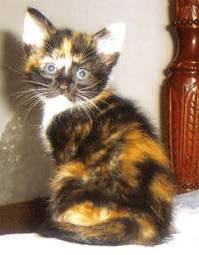

In [13]:
img = Image.open(test_cat)
img

In [14]:
preprocess = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
    normalize
])

In [15]:
img_tensor = preprocess(img)
img_tensor = img_tensor.unsqueeze(0)
img_tensor.to(device);

In [21]:
model.eval()
pred_logits_tensor = model(img_tensor)
pred_probs = nn.functional.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()[0]
pred_probs

array([1.0000000e+00, 2.7656466e-27], dtype=float32)

In [22]:
pred_prob = pred_probs[0]
if pred_prob > 0.5:
    print("IT'S A CAT! ({:.2})".format(pred_prob))
else:
    print("IT'S A DOG! ({:.2})".format(pred_prob))

IT'S A CAT! (1.0)
